Importing Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import tensorflow as tf
import keras
from tensorflow.keras.models  import Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras import Sequential
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

Creating Folders

In [2]:
import os

Root_dir = "Brain_Tumor_Detection_image"

# Print the current working directory to verify the base path
print("Current Working Directory:", os.getcwd())

# Check if the Root_dir exists
if not os.path.exists(Root_dir):
    print(f"Error: The directory '{Root_dir}' does not exist.")
else:
    number_of_images = {}

    # List the contents of the Root_dir to verify it
    print("Contents of the Root_dir:", os.listdir(Root_dir))

    for dir in os.listdir(Root_dir):
        dir_path = os.path.join(Root_dir, dir)
        if os.path.isdir(dir_path):
            number_of_images[dir] = len(os.listdir(dir_path))

    print("Number of images in each directory:", number_of_images.items())


Current Working Directory: c:\Users\sures\Downloads\Video\brain_detetctuon_project\Brain-Tumor-Detector
Contents of the Root_dir: ['Normal', 'Tumor']
Number of images in each directory: dict_items([('Normal', 1500), ('Tumor', 1500)])


# we will  split the data such that
 * 70% for Train Data
 * 15% for Validation 
 * 15 % for testing

In [3]:
def dataFolder(path,split,Root_dir,number_of_images):
    if not os.path.exists(path):
        os.mkdir(path)
   
        for dir in os.listdir(Root_dir):
            new_dir_path = os.path.join(path, dir)
            os.makedirs(new_dir_path)
     
            for img in np.random.choice(a=os.listdir(os.path.join(Root_dir, dir)),
                                        size=math.floor(split * number_of_images[dir]),
                                        replace=False):
                original_image_path = os.path.join(Root_dir, dir, img)
                destination_image_path = os.path.join(new_dir_path, img)
                shutil.copy(original_image_path, destination_image_path)
                os.remove(original_image_path)
    else:
        print(f"{path} folder exists")
  
  
  
   

In [4]:
dataFolder("Train",0.7,Root_dir,number_of_images)
dataFolder("Test",0.15,Root_dir,number_of_images)
dataFolder("Validation",0.15,Root_dir,number_of_images)


#     Data Augmentation


In [5]:
def preprocessingtrainImages(path):
    
    image_data = ImageDataGenerator(
                                    zoom_range=0.2,
                                    shear_range=0.2,
                                    preprocessing_function=preprocess_input,
                                    horizontal_flip=True)
                                    
    image = image_data.flow_from_directory(directory=path,
                                           target_size=(224,224),
                                           batch_size = 32,
                                           class_mode='binary')
    return image


def preprocessingTestvalImages(path):
    image_data = ImageDataGenerator(preprocessing_function=preprocess_input)
    image = image_data.flow_from_directory(directory=path,
                                           target_size=(224,224),
                                           batch_size = 32,
                                           class_mode='binary')
    return image


In [6]:
train_path ="Train"
train_data=preprocessingtrainImages(train_path)

test_path="Test"
test_data=preprocessingTestvalImages(test_path)

validation_path="Validation"
validation_data=preprocessingTestvalImages(validation_path)

Found 2100 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


In [7]:
num_train_images= train_data.n
print(f"Number of images in the training dataset: {num_train_images}")

Number of images in the training dataset: 2100


# Model Building


In [8]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
conv_base.trainable = False
inputs = Input(shape=(224, 224, 3))
x = conv_base(inputs, training=False)  # Pass inputs through conv_base
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)




In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


Callbacks And EarlyStopping

In [11]:

mc = ModelCheckpoint(monitor="val_accuracy",filepath="bestmodel.keras",verbose=1,save_best_only=True)
es = EarlyStopping(monitor="val_accuracy",min_delta=0.001,patience=10,verbose=1)
cd = [mc,es]

# Model Training

In [12]:
hist = model.fit(train_data,
                 epochs=20,
                validation_data=validation_data,
                callbacks=cd
                )

Epoch 1/20


c:\Users\sures\Downloads\Video\brain_detetctuon_project\Brain-Tumor-Detector\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8309 - loss: 0.4591
Epoch 1: val_accuracy improved from -inf to 0.95111, saving model to bestmodel.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 278s 4s/step - accuracy: 0.8318 - loss: 0.4572 - val_accuracy: 0.9511 - val_loss: 0.1470
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9563 - loss: 0.1227
Epoch 2: val_accuracy improved from 0.95111 to 0.97778, saving model to bestmodel.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.9563 - loss: 0.1226 - val_accuracy: 0.9778 - val_loss: 0.0668
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9767 - loss: 0.0734
Epoch 3: val_accuracy improved from 0.97778 to 0.98889, saving model to bestmodel.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.9767 - loss: 0.0734 - val_accuracy: 0.9889 - val_loss: 0.0411
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9761 - loss: 0.0598
Epoch 4: val_accuracy did not improve from 0.98889
66/66 ━━━━━━━━━━━━━

In [13]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,985,861 (129.65 MB)

 Trainable params: 6,423,553 (24.50 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

 Optimizer params: 12,847,108 (49.01 MB)

# Model Evaluation

In [14]:
acc_first=model.evaluate(test_data)[1]
print(f"Accuracy: {acc_first*100} %")

15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9891 - loss: 0.0477
Accuracy: 98.66666793823242 %


In [77]:
try:
    model_best= load_model("bestmodel.keras")
except Exception as e:
    print("Error loading the model:", e)
    

acc = model_best.evaluate(test_data)[1]
print(f"Accuracy: {acc*100} %")

15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9749 - loss: 0.0544
Accuracy: 97.55555391311646 %


In [19]:
test_data.class_indices

{'Normal': 0, 'Tumor': 1}

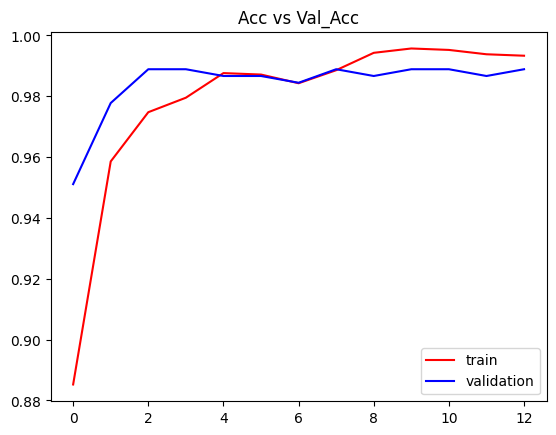

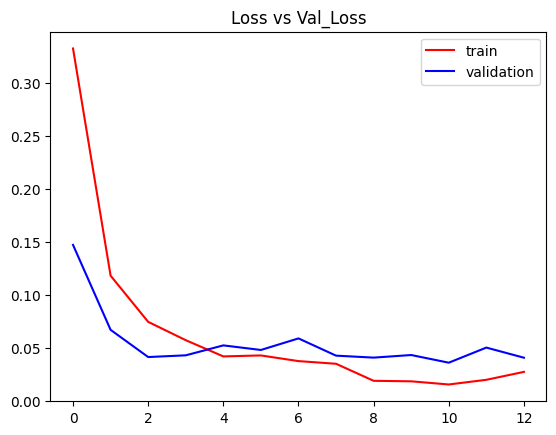

In [76]:
h= hist.history
h.keys()

plt.plot(h['accuracy'],color='red',label='train')
plt.plot(h['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.title("Acc vs Val_Acc")
plt.show()

plt.plot(h['loss'],color='red',label='train')
plt.plot(h['val_loss'],color='blue',label='validation')
plt.legend()
plt.title("Loss vs Val_Loss")
plt.show()

# Model Prediction

In [78]:
def predictor(path):
  
  img=load_img(path,target_size=(224,224))

  img_array=img_to_array(img)
  img1=preprocess_input(img_array)
  input_arr = np.array([img1])
  plt.imshow(img)
  plt.title('MRI Image')


  print("Input shape:", input_arr.shape)


  pred = model_best.predict(input_arr)
  pred1 = model.predict(input_arr)

  print("Prediction output:", pred)
  print("Prediction output:", pred1)

  if pred[0][0]<0.5:
    print("The MRI image is of  Healthy Brain")
  else:
    print("The MRI image is of Brain Tumor")



Input shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Prediction output: [[0.99861133]]
Prediction output: [[0.99990857]]
The MRI image is of Brain Tumor


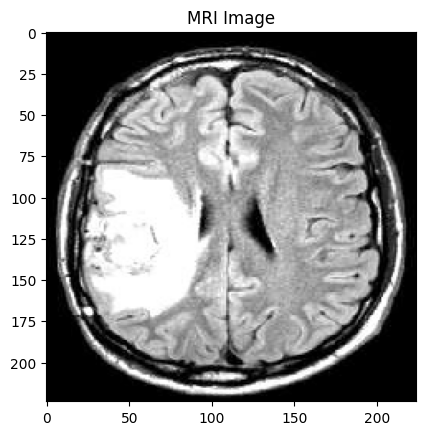

In [79]:
path=r"Test\Tumor\y307.jpg"
predictor(path)